<a href="https://colab.research.google.com/github/Sadiya-Afroz/23455777-Sadiya-Afroz/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [ ]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai


In [ ]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: 395138d1eb0d4a39b6ce9d8a7a7c2f8c.sGzR6Fs8F-H4RGjUzBbcBn9p


## 📦 Setup and Configuration
Import required packages and setup environment.

In [18]:
!pip install pyinputplus
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Add any other setup code here

## 🌤️ Weather Data Functions

In [20]:
import fetch_my_weather

def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location using the fetch-my-weather package.

    Args:
        location (str): City or location name (e.g. "Perth")
        forecast_days (int): Number of days to forecast (1–5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    try:
        # Use mock mode while testing, disable for real data
        fetch_my_weather.set_mock_mode(True)

        # Fetch data in simple JSON dictionary format
        weather = fetch_my_weather.get_weather(location=location, format="raw_json")

        if not weather:
            print("⚠️ No data returned. Check your internet connection or location spelling.")
            return None

        # Only keep up to 'forecast_days' days of data
        if "weather" in weather:
            weather["weather"] = weather["weather"][:forecast_days]

        return weather

    except Exception as e:
        print("❌ Error fetching weather data:", e)
        return None


## 📊 Visualisation Functions

In [ ]:
import matplotlib.pyplot as plt

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a line chart showing the average temperature for each forecast day.

    Args:
        weather_data (dict): The weather data returned by get_weather_data()
        output_type (str): 'display' to show in notebook, 'figure' to return the chart object

    Returns:
        If output_type == 'figure', returns the matplotlib Figure object.
        Otherwise, displays the chart directly in the notebook.
    """
    # Try to get forecast section
    days = weather_data.get("weather", [])
    if not days:
        print("⚠️ No forecast data available.")
        return

    dates = []
    temps = []

    for day in days:
        date = day.get("date", "N/A")
        avg_temp = day.get("avgtempC") or day.get("avgtemp", 0)
        try:
            avg_temp = int(avg_temp)
        except Exception:
            avg_temp = 0
        dates.append(date)
        temps.append(avg_temp)

    if not any(temps):
        print("⚠️ Temperature data missing or zero — check your data source.")
        return

    fig = plt.figure()
    plt.plot(dates, temps, marker='o', color='orange', linewidth=2)
    plt.title("Average Temperature Over Time (°C)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)

    if output_type == 'figure':
        return fig
    else:
        plt.show()



def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create a bar chart showing the chance of rain for each forecast day.

    Args:
        weather_data (dict): The weather data returned by get_weather_data()
        output_type (str): 'display' to show in notebook, 'figure' to return the chart object

    Returns:
        If output_type == 'figure', returns the matplotlib Figure object.
        Otherwise, displays the chart directly in the notebook.
    """
    days = weather_data.get("weather", [])
    if not days:
        print("⚠️ No forecast data available.")
        return

    dates = []
    rain_chances = []

    for day in days:
        date = day.get("date", "N/A")

        # Safely access hourly data
        hourly = day.get("hourly", [])
        if not hourly:
            rain_chance = 0
        else:
            # Choose midday record if available
            midday = hourly[4] if len(hourly) > 4 else hourly[0]
            # Some APIs use 'chanceofrain', others use 'chance_of_rain'
            rain_chance = midday.get("chanceofrain") or midday.get("chance_of_rain") or 0
            try:
                rain_chance = int(rain_chance)
            except Exception:
                rain_chance = 0

        dates.append(date)
        rain_chances.append(rain_chance)

    if not any(rain_chances):
        print("⚠️ No precipitation data found — check your data structure or API mode.")
        return

    fig = plt.figure()
    plt.bar(dates, rain_chances, color='skyblue')
    plt.title("Chance of Rain (%)")
    plt.xlabel("Date")
    plt.ylabel("Chance (%)")
    plt.ylim(0, 100)

    if output_type == 'figure':
        return fig
    else:
        plt.show()


## 🤖 Natural Language Processing

In [25]:
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question (e.g., "Will it rain tomorrow in Sydney?")

    Returns:
        dict: Extracted information including location, time period, and weather attribute.
              Example: {"topic": "rain", "location": "Sydney", "time": "tomorrow"}
    """
    # Make everything lowercase for easier comparison
    q = (question or "").lower()

    # Default topic
    topic = "general"

    # Detect topic keywords
    if "rain" in q or "umbrella" in q:
        topic = "rain"
    elif "temperature" in q or "hot" in q or "cold" in q or "warm" in q:
        topic = "temperature"
    elif "wind" in q:
        topic = "wind"
    elif "humid" in q or "humidity" in q:
        topic = "humidity"

    # Detect time period
    time = "today"
    if "tomorrow" in q:
        time = "tomorrow"
    elif "weekend" in q:
        time = "weekend"

    # Try to find location after the word "in"
    location = None
    if " in " in q:
        location = q.split(" in ", 1)[1].strip(" ?.,!")

    # Return all extracted info
    return {
        "topic": topic,
        "location": location,
        "time": time
    }


## 🧭 User Interface

🌦️ Welcome to WeatherWise!

Main Menu - Choose an option:
1. Run once
2. Quit
1
🌍 Enter a city name (e.g., Perth, Sydney): Perth

📋 Current Weather Summary:
🌤️ Right now it’s 17°C with partly cloudy, humidity 71%, and wind speed around 11 km/h.

📈 Generating charts...


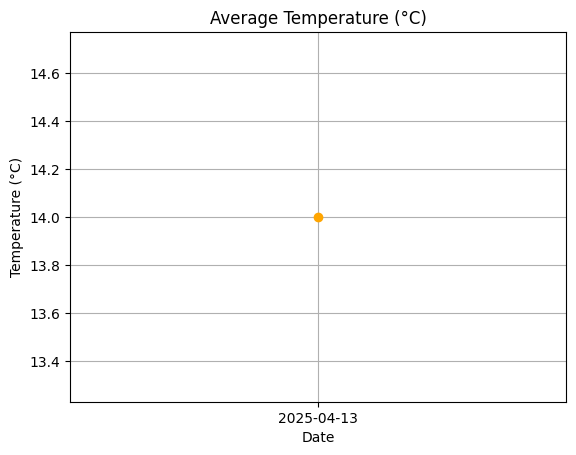

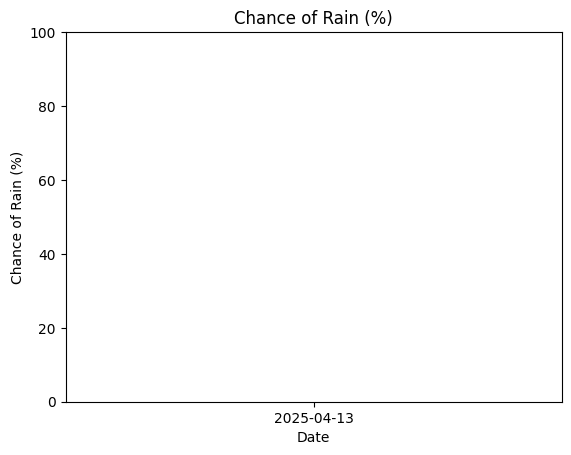


💬 Ask a weather question (e.g., Will it rain tomorrow in Perth?): 

In [ ]:
import pyinputplus as pyip

def run_once():
    """
    Run one full weather check session:
    - Ask for a city
    - Display current summary
    - Show temperature and rain charts
    - Answer one natural language question
    """
    # Ask for a city name
    city = pyip.inputStr("🌍 Enter a city name (e.g., Perth, Sydney): ")

    # Fetch weather data
    weather_data = get_weather_data(city)
    if not weather_data:
        print("⚠️ Could not fetch data. Please try again.")
        return

    # Display current summary
    print("\n📋 Current Weather Summary:")
    print(generate_weather_response({"topic": "general"}, weather_data))

    # Show charts
    print("\n📈 Generating charts...")
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)

    # Let user ask a question
    question = pyip.inputStr("\n💬 Ask a weather question (e.g., Will it rain tomorrow in Perth?): ")
    parsed = parse_weather_question(question)

    # Use the location from the question if provided
    if parsed.get("location") and parsed["location"].lower() != city.lower():
        weather_data = get_weather_data(parsed["location"])

    # Generate and show the response
    print("\n🤖 Answer:")
    print(generate_weather_response(parsed, weather_data))


def main_menu():
    """
    A simple text-based main menu.
    Lets the user choose to run the app or quit.
    """
    print("🌦️ Welcome to WeatherWise!")
    while True:
        choice = pyip.inputMenu(
            ["Run once", "Quit"],
            numbered=True,
            prompt="\nMain Menu - Choose an option:\n"
        )

        if choice == "Run once":
            run_once()
        else:
            print("👋 Goodbye! Stay safe and check the weather again soon.")
            break


# 🚀 Launch the main menu
main_menu()


## 🧩 Main Application Logic

In [27]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data from get_weather_data()

    Returns:
        str: A simple, human-friendly weather response.
    """
    if not weather_data:
        return "⚠️ Sorry, I couldn’t find any weather information right now."

    try:
        # Get basic current conditions
        current = weather_data.get("current_condition", [{}])[0]
        temp_c = current.get("temp_C", "N/A")
        condition = current.get("weatherDesc", [{"value": "unknown"}])[0]["value"]
        humidity = current.get("humidity", "N/A")
        wind = current.get("windspeedKmph", "N/A")

        topic = parsed_question.get("topic", "general")
        time = parsed_question.get("time", "today")

        # Start building a reply
        if topic == "rain":
            # Get today's rain chance
            today = weather_data.get("weather", [{}])[0]
            hourly = today.get("hourly", [])
            midday = hourly[4] if len(hourly) > 4 else (hourly[0] if hourly else {})
            chance = midday.get("chanceofrain", "N/A")
            response = f"☔ The chance of rain {time} is around {chance}%. Current condition: {condition}."

        elif topic == "temperature":
            response = f"🌡️ The temperature {time} is around {temp_c}°C with {condition.lower()} conditions."

        elif topic == "wind":
            response = f"🌬️ The wind speed {time} is about {wind} km/h. It’s currently {condition.lower()}."

        elif topic == "humidity":
            response = f"💧 The humidity {time} is about {humidity}%. It’s {condition.lower()} outside."

        else:
            response = (
                f"🌤️ Right now it’s {temp_c}°C with {condition.lower()}, "
                f"humidity {humidity}%, and wind speed around {wind} km/h."
            )

        return response

    except Exception as e:
        return f"⚠️ Sorry, I couldn’t generate the weather response. ({e})"


## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.